In [1]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D, SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.fft import fft2, fftshift
import os
import numpy as np
from astropy.io import fits
from skimage.transform import AffineTransform, warp
import matplotlib.pyplot as plt
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# DDO 101

(644, 1057)


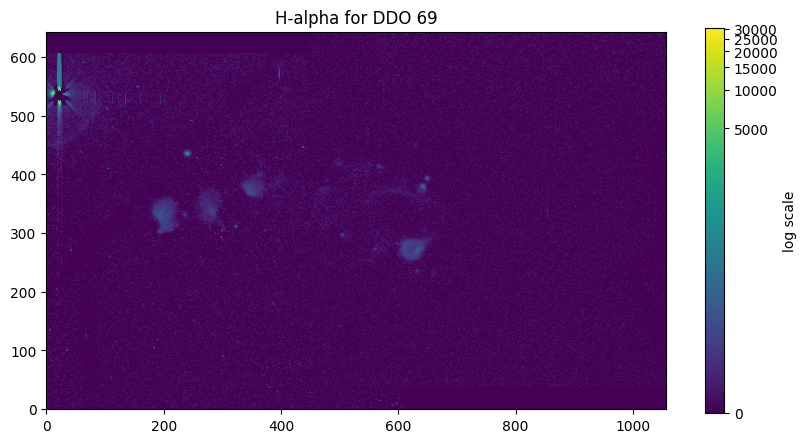

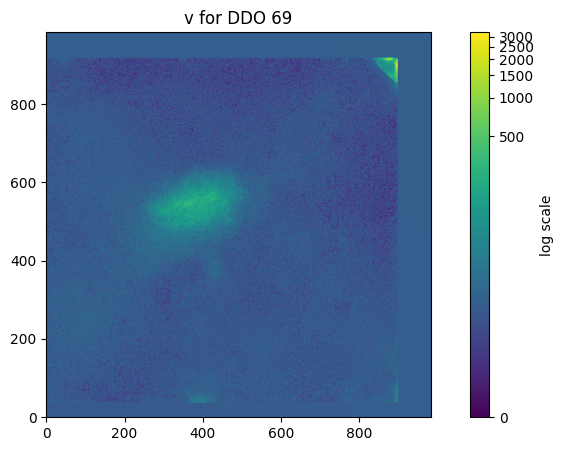

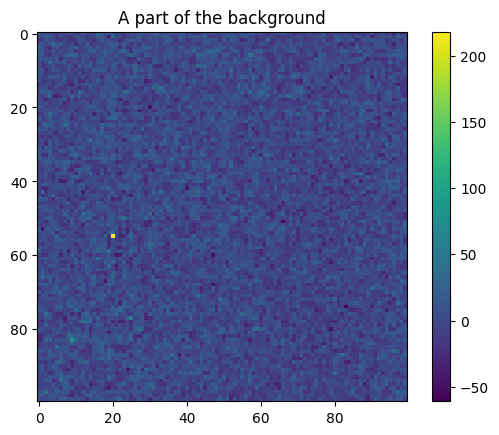

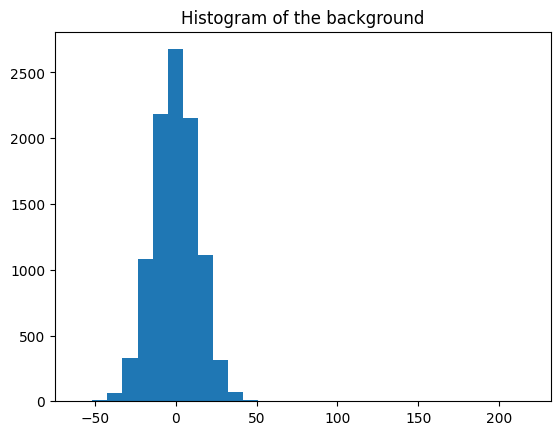

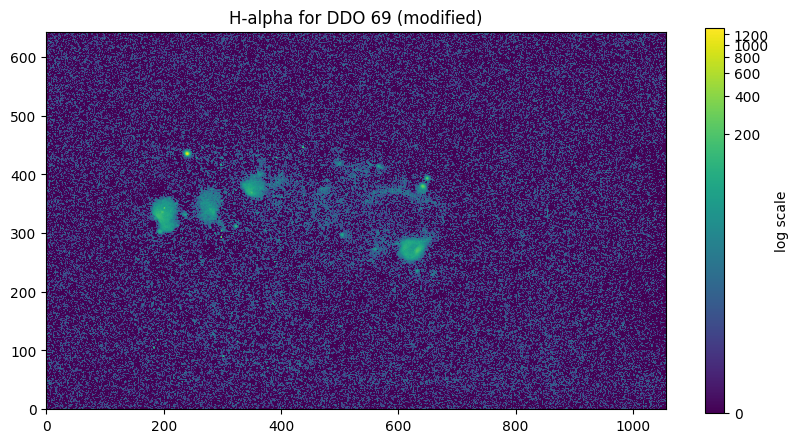

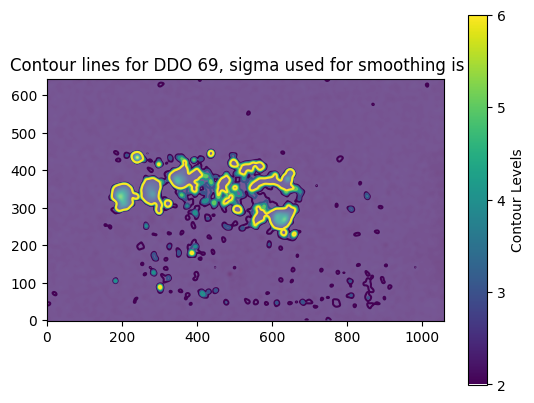

In [2]:
galaxy_name = "DDO 69"
DDO69_H = ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO69\d69hmrms.fits")
DDO69_V = ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d69\starless1\starless_DDO69_V_background_subtracted.fit")
print(np.shape(DDO69_H))
# Trim the image
DDO69_H_trimmed = DDO69_H[40:450, 150:]
ltf.log_scale_plot(DDO69_H, f"H-alpha for {galaxy_name}", "log scale")
ltf.log_scale_plot(DDO69_V, f"v for {galaxy_name}", "log scale")

# Generate the replacement values from a normal distribution
chunk = DDO69_H[:100, :100]
mean = np.mean(chunk)
std_dev = np.std(chunk)

# Create a full array with replacement values
DDO69_H_replaced = np.random.normal(loc=mean, scale=std_dev, size=DDO69_H.shape)

# Copy the trimmed portion back into the original image shape
DDO69_H_replaced[40:450, 150:] = DDO69_H_trimmed

# For visual confirmation, plot the chunk histogram
plt.imshow(chunk)
plt.title("A part of the background")
plt.colorbar()
plt.show()
plt.hist(chunk.flatten(), bins=30)
plt.title("Histogram of the background")
#plt.show()
# Plot the modified data
ltf.log_scale_plot(DDO69_H_replaced, f"H-alpha for {galaxy_name} (modified)", "log scale")

sigma = 5

# Assuming DDO101_H_replaced is already defined
smoothed = gaussian_filter(DDO69_H_replaced, sigma)

fig, ax = plt.subplots()
im = ax.imshow(smoothed, alpha=0.75, origin="lower")

# Create the contour plot
levels = [2, 3, 4, 5, 6]
CS = ax.contour(smoothed, levels, cmap='viridis')

# Create a custom color bar for the contour lines
norm = Normalize(vmin=2, vmax=6)  # Adjust this range according to your contour levels
sm = cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Add the color bar with labels
cbar = fig.colorbar(sm, ax=ax, ticks=levels)
cbar.ax.set_yticklabels([str(level) for level in levels])
cbar.set_label('Contour Levels')

plt.title(f"Contour lines for {galaxy_name}, sigma used for smoothing is {sigma}")
plt.show()

# Specify the output directory and file name
output_dir = r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d69"
output_path = os.path.join(output_dir, f"{galaxy_name}_replaced.fits")

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the replaced array to a new FITS file
fits.writeto(output_path, DDO69_H_replaced.astype(np.float32), overwrite=True)



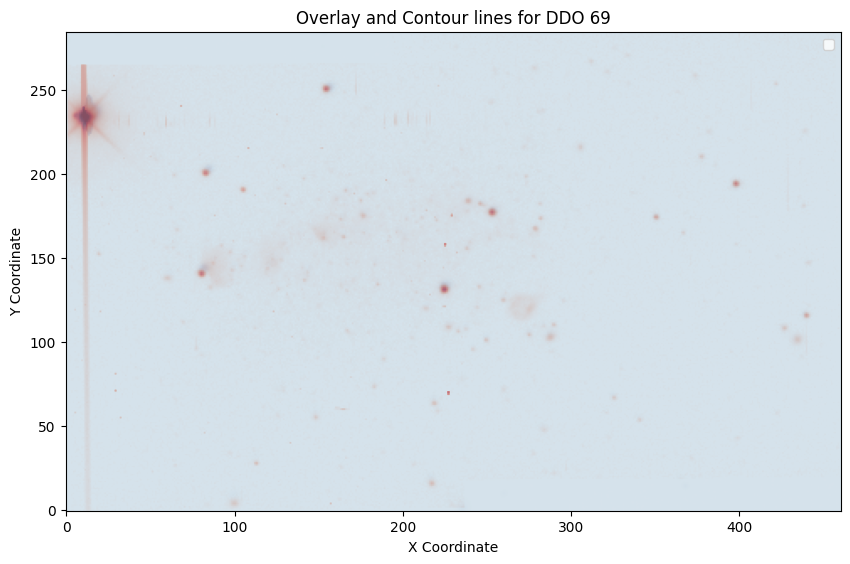

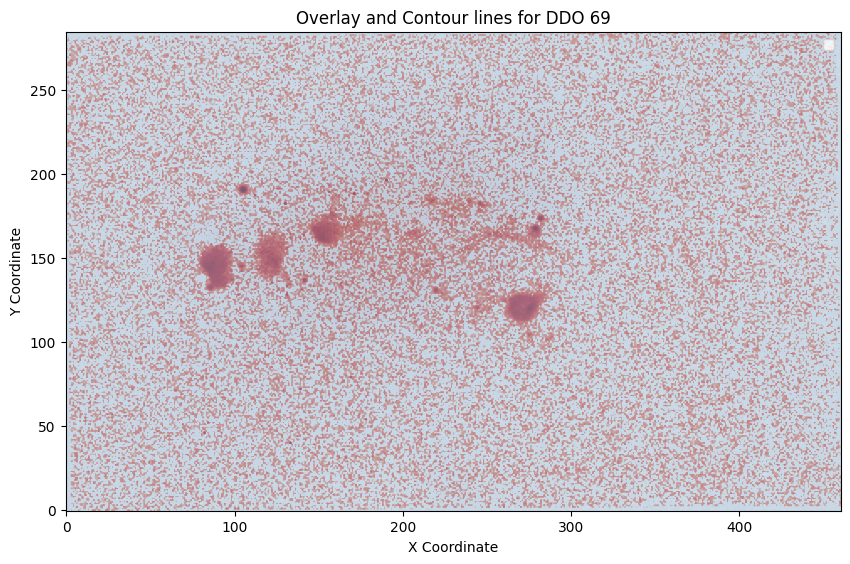

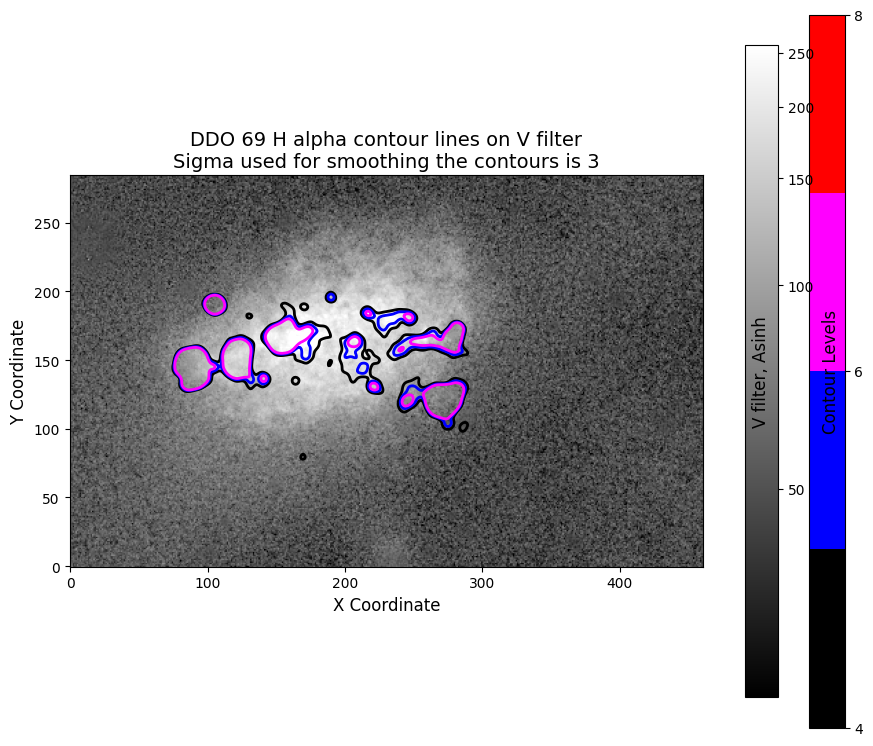

H-alpha pixelscale: 0.4919905376750834


In [3]:
image1_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO69\d69_V.fits"
image2_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO69\d69ha.fits"
output_dir = r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d69"

star_coords_V = np.array([[640,534], [593,514], [548, 556]])
star_coords_H = np.array([[917,438], [808,393], [705,490]])

V_with_stars, H_with_stars = ltf.V_and_Halpha_alignment(galaxy_name, image1_path, image2_path, star_coords_V, star_coords_H, output_dir, alpha1=0.5, alpha2=0.5)

image1_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\d69\starless_backgroundless_d69v_aligned.fits.fit"
image2_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d69\DDO 69_replaced.fits"
V_pixelscale = 1.134
V_image , H_image = ltf.V_and_Halpha_alignment(galaxy_name, image1_path, image2_path, star_coords_V, star_coords_H, output_dir, alpha1=0.5, alpha2=0.5)
ltf.plot_contours_V_and_Halpha(galaxy_name, V_image, H_image, folder_path=r"C:\Users\AYSAN\Desktop\project\Galaxy\H-alpha regions", alpha=1, sigma=3, contour_levels=[4,6,8])
H_pixelscale = ltf.calculate_pixelscale(star_coords_V, star_coords_H, V_pixelscale)
print("H-alpha pixelscale:", H_pixelscale)

# Resolution DDO 69

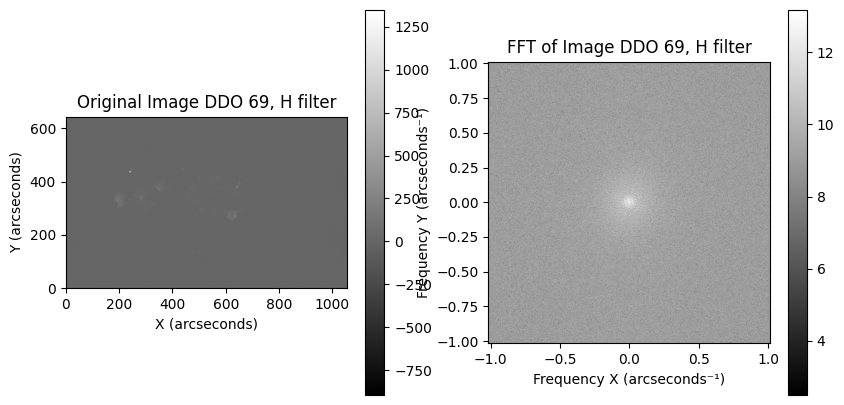

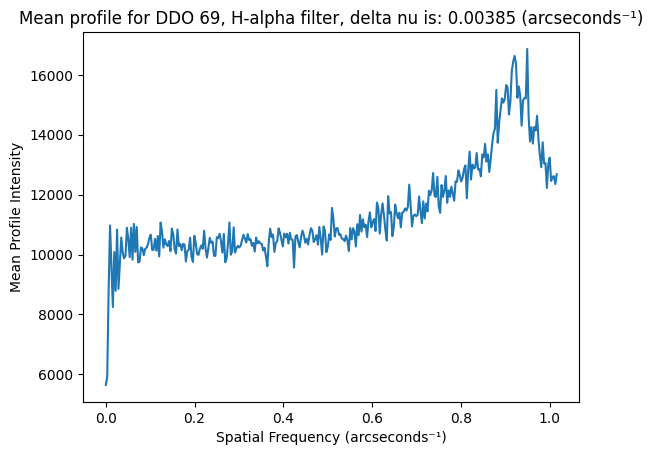

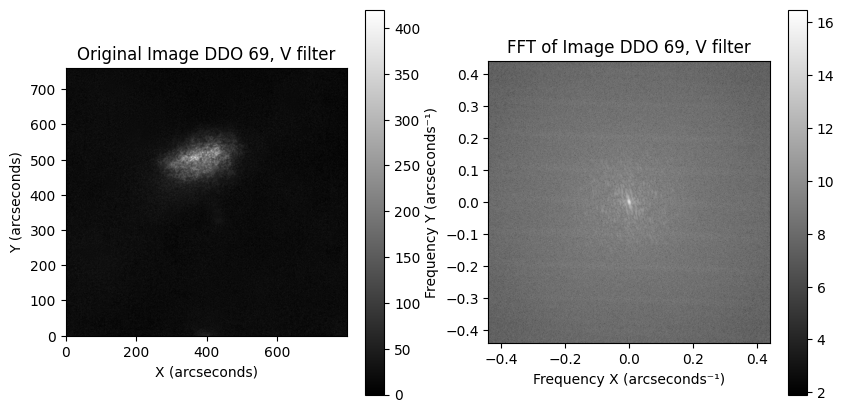

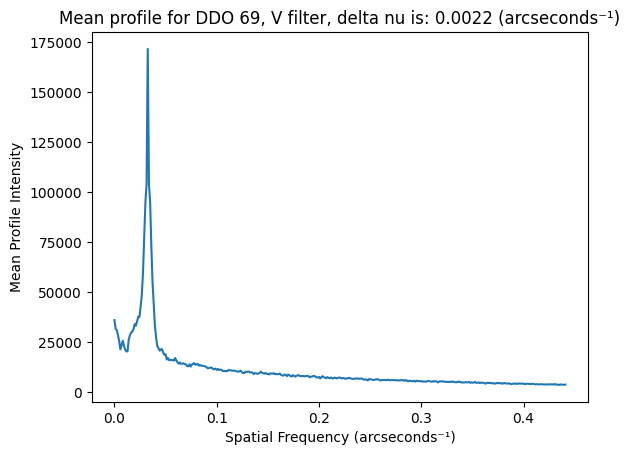

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift, fftfreq

def compute_fft(image):
    fft_image = fft2(image)
    fft_image_shifted = fftshift(fft_image)
    return fft_image_shifted

def plot_image_and_fft(image, fft_image_shifted, name, filter, pixelscale):
    plt.figure(figsize=(10, 5))
    
    # Original image with axes in arcseconds
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray', origin='lower')
    plt.colorbar()
    plt.xlabel('X (arcseconds)')
    plt.ylabel('Y (arcseconds)')
    plt.title(f'Original Image {name}, {filter} filter')
    
    # FFT of the image with axes in inverse arcseconds
    plt.subplot(1, 2, 2)
    fft_shape = fft_image_shifted.shape
    freq_x = fftshift(fftfreq(fft_shape[1], d=pixelscale))
    freq_y = fftshift(fftfreq(fft_shape[0], d=pixelscale))
    extent = [freq_x.min(), freq_x.max(), freq_y.min(), freq_y.max()]
    plt.imshow(np.log(np.abs(fft_image_shifted)), cmap='gray', origin='lower', extent=extent)
    plt.colorbar()
    plt.xlabel('Frequency X (arcseconds⁻¹)')
    plt.ylabel('Frequency Y (arcseconds⁻¹)')
    plt.title(f'FFT of Image {name}, {filter} filter')
    
    plt.show()

def get_line_profile(image, start_point, angle, length):
    x0, y0 = start_point
    angle_rad = np.deg2rad(angle)
    profile = []

    for r in range(length):
        x = int(x0 + r * np.cos(angle_rad))
        y = int(y0 + r * np.sin(angle_rad))

        if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
            profile.append(np.abs(image[y, x]))  # Use the magnitude
        else:
            profile.append(np.nan)

    return profile

def resolution(image, name, filter, num_theta, pixelscale):
    fft_image_shifted = compute_fft(image)
    plot_image_and_fft(image, fft_image_shifted, name, filter, pixelscale=pixelscale)
    length = int(np.min(image.shape) / 2)
    center = np.array(image.shape) // 2
    profiles = []
    
    for theta in np.linspace(0, 2 * np.pi, num=num_theta, endpoint=False):
        profile = get_line_profile(fft_image_shifted, center, np.rad2deg(theta), length)
        profiles.append(profile)
    
    mean_profile = np.nanmean(profiles, axis=0)
    
    return profiles, mean_profile, length

# Example usage
# Make sure to define DDO101_H_replaced, DDO101_V, galaxy_name, H_pixelscale, and V_pixelscale appropriately
image = DDO69_H_replaced
profiles, mean_profile, length = resolution(image, galaxy_name, "H", num_theta=360, pixelscale=H_pixelscale)
image_shape = image.shape
x_ax = np.linspace(0, 1/(2*H_pixelscale), length)
dela_nu = np.round(2/(image.shape[1]*H_pixelscale), 5)
plt.plot(x_ax, mean_profile)
plt.xlabel('Spatial Frequency (arcseconds⁻¹)')
plt.ylabel('Mean Profile Intensity')
plt.title(f'Mean profile for {galaxy_name}, H-alpha filter, delta nu is: {dela_nu} (arcseconds⁻¹)')
plt.show()

image = DDO69_V [40:800 , 0:800]
profiles, mean_profile, length = resolution(image, galaxy_name, "V", num_theta=360, pixelscale=V_pixelscale)
image_shape = image.shape
x_ax = np.linspace(0, 1/(2*V_pixelscale), length)
dela_nu = np.round(2/(image.shape[1]*V_pixelscale), 5)
plt.plot(x_ax, mean_profile)
plt.xlabel('Spatial Frequency (arcseconds⁻¹)')
plt.ylabel('Mean Profile Intensity')
plt.title(f'Mean profile for {galaxy_name}, V filter, delta nu is: {dela_nu} (arcseconds⁻¹)')
plt.show()
